In [624]:
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from mplsoccer.pitch import Pitch
import json
from matplotlib.animation import FuncAnimation
import sympy as sp
from sympy import Point, Circle, Eq
import math


In [625]:
def read_json_partially(file_path, start_line, end_line):
    data = []  # List to store extracted JSON objects

    with open(file_path, 'r') as file:
        for line_num, line in enumerate(file):
            if line_num >= start_line and line_num <= end_line:
                # Parse JSON from the line and append it to data
                data.append(json.loads(line))
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data


In [626]:
file_path = '../data/matches/vs FC Lugano/2023-12-06_ReSpo Vision_FC Lugano - FC Basel.jsonl'
start_line = 7500  # Start line number
end_line = 7580  # End line number 

partialframes = read_json_partially(file_path, start_line, end_line)

In [627]:
target = 27
playerFrames = list(map(lambda x: x['players'], partialframes))
targetPositions = []

for index, frame in enumerate(playerFrames):
    if(index % 1 != 0): # We consider only every n-th frame
        continue

    player = list(filter(lambda player: player['person_id'] == target, frame))[0]
    targetPositions.append((player['x'], player['y']))


In [628]:
# takes as input array of length 3
def getCircle(points):
    assert(len(points) == 3)
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    s1 = x1**2 + y1**2
    s2 = x2**2 + y2**2
    s3 = x3**2 + y3**2
    M11 = x1*y2 + x2*y3 + x3*y1 - (x2*y1 + x3*y2 + x1*y3)
    M12 = s1*y2 + s2*y3 + s3*y1 - (s2*y1 + s3*y2 + s1*y3)
    M13 = s1*x2 + s2*x3 + s3*x1 - (s2*x1 + s3*x2 + s1*x3)
    x0 =  0.5*M12/M11
    y0 = -0.5*M13/M11
    r0 = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return ((x0, y0), r0)

source: https://paulbourke.net/geometry/circlesphere/

In [629]:
def getCircleIntersections(c0, r0, c1, r1):
    x0, y0 = c0
    x1, y1 = c1
    d = math.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    # non intersecting
    if d > r0 + r1 :
        return None
    # One circle within other
    if d < abs(r0-r1):
        return None
    # coincident circles
    if d == 0 and r0 == r1:
        return None
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=math.sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d   
        y2=y0+a*(y1-y0)/d   
        x3=x2+h*(y1-y0)/d     
        y3=y2-h*(x1-x0)/d 

        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        
        return ((x3, y3), (x4, y4))

In [630]:
def euclidianDistance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [631]:
def closestPoint(p1, p2, p3, p4):
    if(euclidianDistance(p1, p3) + euclidianDistance(p1, p4) < euclidianDistance(p2, p3) + euclidianDistance(p2, p4)):
        return p1
    else:
        return p2

In [632]:
def areCollinear(p1, p2, p3):
    matrix = np.array([[p1[0], p1[1], 1],
                       [p2[0], p2[1], 1],
                       [p3[0], p3[1], 1]])
    det = np.linalg.det(matrix)
    return np.isclose(det, 0)

In [633]:
def midPoint(p1, p2):
    return ((p1[0] + p2[0])/2, (p1[1] + p2[1])/2)

In [634]:
def computeNewPoints(trajectory):
    new_points = []
    n = len(trajectory)

    for i in range(1, n-2):
        if(i == 1):
            p1 = trajectory[i]
            p2 = trajectory[i+1]
            col1 = areCollinear(trajectory[i-1], p1, p2)            
        else:
            p1 = p2
            c1 = c2
            r1 = r2
            col1 = col2
    
        p2 = trajectory[i+1]
        M = midPoint(p1, p2)
        
        # handling collinear points
        col2 = areCollinear(trajectory[i+2], p1, p2)

        if(not(col1 or col2)):
            if(i == 1):
                c1, r1 = getCircle(trajectory[i-1: i+2])
            c2, r2 = getCircle(trajectory[i: i+3])
            r = 2/(1/r1 + 1/r2)

        elif(col1 and col2):
            new_point = M
            new_points.append(new_point)
            continue

        elif(col1):
            c2, r2 = getCircle(trajectory[i: i+3])
            c1 = (0, 0)
            r1 = float('inf')
            r = 2/(1/r2)

        elif(col2):
            if(i == 1):
                c1, r1 = getCircle(trajectory[i-1: i+2])
            c2 = (0, 0)
            r2 = float('inf')
            r = 2/(1/r1)

        # intersecting the averaging circles
        c_avg1, c_avg2 = getCircleIntersections(p1, r, p2, r)

        # if different oriented curvature in the sequential circles than take the shape of the one with the smallest radius
        min_c = c1 if r1 < r2 else c2
        c_avg = c_avg1 if euclidianDistance(c_avg1, min_c) < euclidianDistance(c_avg2, min_c) else c_avg2
        
        # computing new point
        d = r/euclidianDistance(M, c_avg)
        new_point_1 = np.array(c_avg) + (np.array(M)-np.array(c_avg))*d
        new_point_2 = np.array(c_avg) + (np.array(M)-np.array(c_avg))*(-d)

        new_point = closestPoint(new_point_1, new_point_2, p1, p2)
        
        new_points.append(new_point)
        
        # PLOTTING STUFF ----------------------------------------------------------------------------------------------------

        # plt.scatter(p1[0], p1[1], color="black", marker="o")
        # plt.scatter(new_point[0], new_point[1], color="red", marker="o", s=30)

        # circle = plt.Circle(c1, r1, fill=False, edgecolor="green" if i % 2 == 0 else "red")
        # circle2 = plt.Circle(c_avg, r, fill=False, edgecolor="blue")

        # ax.add_patch(circle)
        # ax.add_patch(circle2)

    return new_points


In [635]:
def performSmoothing(trajectory, iterations):
    for it in range(0, iterations):
        for i in range(0, 2):
            # compute extension points at the beginning/end of the trajectory
            pFirst = (2*trajectory[0][0] - trajectory[1][0], 2*trajectory[0][1] - trajectory[1][1])
            pLast = (2*trajectory[-1][0] - trajectory[-2][0], 2*trajectory[-1][1] - trajectory[-2][1])
            midFirst = midPoint(pFirst, trajectory[0])
            midLast = midPoint(trajectory[-1], pLast)
            
            if(i % 2 != 0):
                og = trajectory.copy()
                updated_traj = computeNewPoints([midFirst] + new_points + [midLast])
                trajectory = [og[0]] + updated_traj + [og[-1]]
            else:
                new_points = computeNewPoints([pFirst] + trajectory + [pLast])
    return (trajectory, new_points)

We partially read the big Frame file with the following function

Current file has granularity of **40ms**

We extract trajectory of targeted player by **ID**

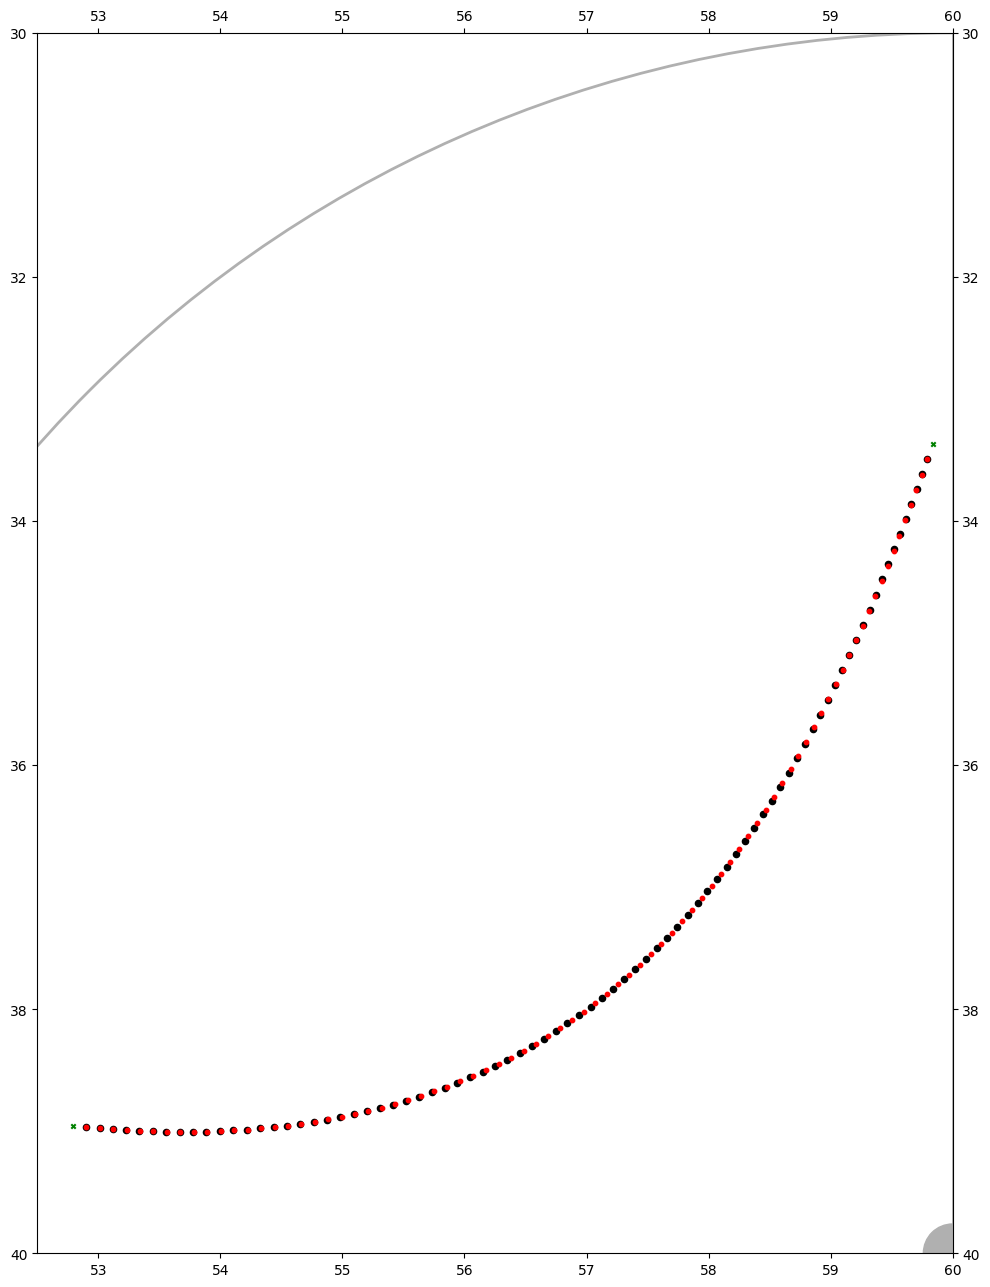

In [636]:
pitch = Pitch(axis=True, label=True, tick=True)
# specifying figure size (width, height)
fig, ax = pitch.draw(figsize=(10, 20))

x, y = zip(*targetPositions)
ax.scatter(x, y, color='black', marker='o', s=20)

# ax.set_xlim(50, 70) 
# ax.set_ylim(40, 10)

ax.set_xlim(52.5, 60) 
ax.set_ylim(40, 30)

# ax.set_xlim(30, 43) 
# ax.set_ylim(40, 30)

traj, new_points = performSmoothing(trajectory=targetPositions, iterations=300)
x, y = zip(*(traj))

for idx, t in enumerate(traj):
    ax.scatter(t[0], t[1], color="red", marker="o", s=10)
    # ax.text(t[0], t[1], f'({idx})')

pFirst = (2*traj[0][0] - traj[1][0], 2*traj[0][1] - traj[1][1])
pLast = (2*traj[-1][0] - traj[-2][0], 2*traj[-1][1] - traj[-2][1])
ax.scatter(pFirst[0], pFirst[1], color="green", marker="x", s=10)
ax.scatter(pLast[0], pLast[1], color="green", marker="x", s=10)

# x, y = zip(*(new_points))
# ax.scatter(x, y, color="green", marker="o", s=40)

plt.show()

**Smoothing**

*Animation*

In [637]:
# for i in range(0, 2000):
#     # x = np.random.rand(3, )
#     # c1, r1 = getCircle([(x, x+3), (x+5, x+5), (x+6, x+4)])
#     c1 = Circle(Point(0, 2), Point(3, 5), Point(6, 4))